# Large Dataset Training

In [1]:
import os
import json
from stelaro.data import synthetic

DATA_DIRECTORY = "../data/"
SUMMARY_DIRECTORY = DATA_DIRECTORY + "ncbi_genome_summaries/"
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
DATASET_V1_DIRECTORY = DATA_DIRECTORY + "version_1/"
DATASET_V1_COMPRESSED_DIRECTORY = DATASET_V1_DIRECTORY + "compressed/"


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)


mkdir(DATA_DIRECTORY)
mkdir(DATASET_V1_DIRECTORY)
mkdir(DATASET_V1_COMPRESSED_DIRECTORY)

## 1. Compress The Dataset

In [3]:
LENGTH = 1500
with open("../datasets/version_1_splits/map.json", "r") as f:
    index_to_taxonomic_label = json.load(f)

for dataset_name in ("validate", "test", "train"):
    with open(f"../datasets/version_1_splits/{dataset_name}.json", "r") as f:
        dataset = json.load(f)
    index_to_n_passes = {}
    directory = DATASET_V1_COMPRESSED_DIRECTORY + dataset_name + "/"
    mkdir(directory)
    synthetic.compress_dataset(
        dataset,
        index_to_taxonomic_label,
        "../data/version_1/genomes/",
        LENGTH,
        directory
    )

100%|██████████| 27/27 [41:05<00:00, 91.32s/it] 


## 2. Sample Data

In [3]:
f = synthetic.get_n_reads_in_compressed_dataset(
    DATASET_V1_COMPRESSED_DIRECTORY + "test/",
)
print(f)
n = sum(f)
ids = synthetic.get_random_identifiers(n)

[ 12643  22777  34943  31102  60816   4144  64119  86229   5006  25801
   5386   8599  29738  22694  37733  15253  58687 118124  85929 137871
  79875 149174  21096  75607  16687   1920    346]


In [5]:
from numpy import bincount
x, y = synthetic.sample_compressed_dataset(
    DATASET_V1_COMPRESSED_DIRECTORY + "train/",
    200_000,
    1500,
    ids,
    400000
)
print(bincount(y))
print(sum(bincount(y)))

[ 5398 12157  2987  6817  6141   994 13232 13711  2553  8935  3209  3800
 12401  5645  3268  1090  8832  6483  9312 12444 11964 13768 16315 14968
  3098   407    71]
200000


In [14]:
with open(f"../datasets/version_1_splits/train.json", "r") as f:
    dataset = json.load(f)


taxon = dataset[-1]
print(taxon[0])
references = []
for element in taxon[1]:
    genus, ref = element
    references += ref
print(synthetic.evaluate_n_nucleotides(references))


['Viruses', 'Monodnaviria']
5158834


In [7]:
import numpy as np
x = np.load(DATASET_V1_COMPRESSED_DIRECTORY + "train/0_x.npy")
print(x.shape)

(1000000, 375)


## 3. Train Neural Networks

In [ ]:
from stelaro import models
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from stelaro.models import feedforward, autoencoder, transformer
from time import time

LENGTH = 1500
BATCH_SIZE = 128

train_data = DataLoader(
    synthetic.CompressedReadDataset(
        "../data/version_1/compressed/train/", 20_000
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)
validate_data = DataLoader(
    synthetic.SyntheticReadDataset(
        "../data/version_1/compressed/validate/", 50_000, LENGTH
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_data = DataLoader(
    synthetic.SyntheticReadDataset(
        "../data/version_1/compressed/test/", 50_000, LENGTH
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

with open("../data/version_1/static/train/map.json", "r") as f:
    mapping = json.load(f)


def benchmark(classifier: models.BaseClassifier, name: str, n_max_reads=30_000):
    train_data.dataset.reset()
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=0.001)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, f1 = classifier.train_large_dataset(
        train_data,
        validate_data,
        optimizer,
        evaluation_interval=50_000,
        n_max_reads=n_max_reads,
        patience=4,
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        x = list(range(len(losses)))
        ax[0].plot(x, losses, label="losses")
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].set_title("Loss")
        ax[1].set(xlabel='Epochs', ylabel="f1")
        ax[1].set_title("F1 Score")
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        fig.suptitle(f"Classification Training for {name}")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping, permute=False)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test results: {rounded_result}")
    return classifier

In [3]:
model = benchmark(
    models.RandomClassifier(),
    "Random Classifier",
    n_max_reads=30_000
)

  0%|          | 234/68609 [00:01<06:37, 172.22it/s]


Training took 1.369 s.
Test results: [0.32248, 0.024849]


d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


Number of parameters: 35_967_928


  1%|          | 391/68609 [04:50<217:09:54, 11.46s/it]

N Reads: 50048 Loss: 1014.34. F1: [0.3188, 0.081866]. Patience: 10


  1%|          | 782/68609 [09:24<219:04:31, 11.63s/it]

N Reads: 100096 Loss: 904.88. F1: [0.32111, 0.10223]. Patience: 10


  2%|▏         | 1173/68609 [13:56<209:44:45, 11.20s/it]

N Reads: 150144 Loss: 819.95. F1: [0.39712, 0.1658]. Patience: 10


  2%|▏         | 1564/68609 [18:36<216:31:10, 11.63s/it]

N Reads: 200192 Loss: 753.27. F1: [0.38245, 0.19057]. Patience: 10


  3%|▎         | 1955/68609 [23:39<212:11:03, 11.46s/it]

N Reads: 250240 Loss: 710.91. F1: [0.38968, 0.19594]. Patience: 10


  3%|▎         | 2346/68609 [28:15<215:55:40, 11.73s/it]

N Reads: 300288 Loss: 680.10. F1: [0.40884, 0.21159]. Patience: 10


  4%|▍         | 2737/68609 [32:48<206:33:11, 11.29s/it]

N Reads: 350336 Loss: 659.96. F1: [0.41708, 0.21979]. Patience: 10


  5%|▍         | 3128/68609 [37:23<213:24:43, 11.73s/it]

N Reads: 400384 Loss: 640.30. F1: [0.43272, 0.23905]. Patience: 10


  5%|▌         | 3519/68609 [41:56<204:49:36, 11.33s/it]

N Reads: 450432 Loss: 624.48. F1: [0.43124, 0.26343]. Patience: 10


  6%|▌         | 3910/68609 [46:32<208:07:09, 11.58s/it]

N Reads: 500480 Loss: 613.78. F1: [0.42948, 0.23022]. Patience: 9


  6%|▋         | 4301/68609 [51:05<200:18:43, 11.21s/it]

N Reads: 550528 Loss: 611.30. F1: [0.46459, 0.25495]. Patience: 8


  7%|▋         | 4692/68609 [55:41<204:55:57, 11.54s/it]

N Reads: 600576 Loss: 595.30. F1: [0.47465, 0.25034]. Patience: 7


  7%|▋         | 5083/68609 [1:00:14<200:05:05, 11.34s/it]

N Reads: 650624 Loss: 593.74. F1: [0.45299, 0.2579]. Patience: 6


  8%|▊         | 5474/68609 [1:04:49<198:08:21, 11.30s/it]

N Reads: 700672 Loss: 581.64. F1: [0.47899, 0.27539]. Patience: 6


  9%|▊         | 5865/68609 [1:09:22<196:35:09, 11.28s/it]

N Reads: 750720 Loss: 582.94. F1: [0.47104, 0.26316]. Patience: 5


  9%|▉         | 6256/68609 [1:13:56<193:53:10, 11.19s/it]

N Reads: 800768 Loss: 577.25. F1: [0.46753, 0.28047]. Patience: 5


 10%|▉         | 6647/68609 [1:18:29<194:36:46, 11.31s/it]

N Reads: 850816 Loss: 572.50. F1: [0.48996, 0.26628]. Patience: 4


 10%|█         | 7038/68609 [1:23:35<192:41:02, 11.27s/it]

N Reads: 900864 Loss: 569.97. F1: [0.51782, 0.26039]. Patience: 3


 11%|█         | 7429/68609 [1:28:08<190:34:00, 11.21s/it]

N Reads: 950912 Loss: 561.05. F1: [0.49371, 0.28871]. Patience: 3


 11%|█▏        | 7820/68609 [1:32:43<191:08:41, 11.32s/it]

N Reads: 1000960 Loss: 556.69. F1: [0.49898, 0.29051]. Patience: 3


 12%|█▏        | 8211/68609 [1:37:16<186:57:51, 11.14s/it]

N Reads: 1051008 Loss: 557.10. F1: [0.49498, 0.29685]. Patience: 3


 13%|█▎        | 8602/68609 [1:43:09<195:38:03, 11.74s/it]

N Reads: 1101056 Loss: 551.18. F1: [0.49961, 0.27727]. Patience: 2


 13%|█▎        | 8993/68609 [1:48:06<186:58:01, 11.29s/it]

N Reads: 1151104 Loss: 544.17. F1: [0.48188, 0.29339]. Patience: 1


 14%|█▎        | 9375/68609 [1:52:30<11:50:49,  1.39it/s] 

Reached the specified maximum number of reads.
Training took 6750.201 s.


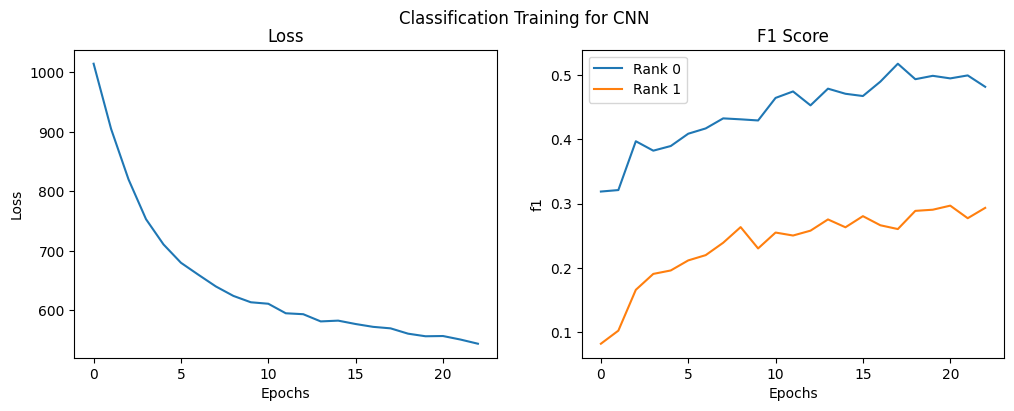

Test results: [0.50311, 0.30104]


In [38]:
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d)
from torch import stack, tensor, float32
from torch.func import vmap
import torch.nn.functional as F


class CNN_2_dropout_token(Module):
    def __init__(self, N, M):
        super(CNN_2_dropout_token, self).__init__()
        self.conv = Sequential(
            Conv1d(4, 32, kernel_size=7, padding=3),
            ReLU(),
            Conv1d(32, 64, kernel_size=5, padding=2),
            ReLU(),
            Conv1d(64, 128, kernel_size=3, padding=1),
            ReLU(),
        )
        n = N * 4
        self.fc = Sequential(
            Flatten(),
            Dropout(0.2),
            Linear(n * 128, int(n / 8)),
            ReLU(),
            Dropout(0.2),
            Linear(int(n / 8), 128),
            ReLU(),
            Dropout(0.2),
            Linear(128, M)
        )

    def forward(self, x):
        B, N = x.shape
        shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
        x_expanded = x.unsqueeze(-1).to(int)
        tokens = (x_expanded >> shifts) & 0b11
        tokens = tokens.view(B, N * 4)
        one_hot = F.one_hot(tokens, num_classes=4).float()
        x = one_hot.permute(0, 2, 1)
        x = self.conv(x)
        x = self.fc(x)
        return x.to(float)


model = benchmark(
    feedforward.Classifier(LENGTH // 4, mapping, "cuda", CNN_2_dropout_token),
    "CNN",
    n_max_reads=1_200_000
)

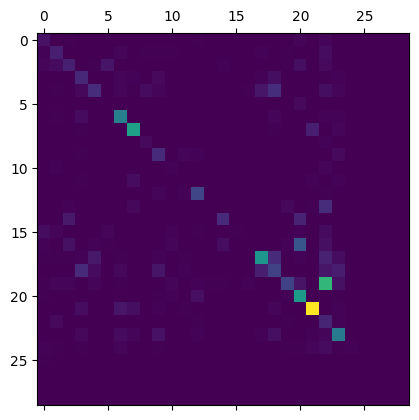

In [41]:
from torch import no_grad
import numpy as np

def confusion_matrix(classifier, loader, device, mapping) -> np.ndarray:
    """Returns: A confusion matrix with rows corresponding to true labels."""
    matrix = np.zeros((len(mapping), len(mapping)))
    with no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.type(float32).to(device)
            #x_batch = x_batch.permute(0, 2, 1)  # Swap channels and sequence.
            y_batch = y_batch.to("cpu")
            predictions = classifier.predict(x_batch)
            for y, p in zip(y_batch, predictions):
                matrix[y][p] += 1
    return matrix

matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()

In [46]:
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)
print(np.sum(matrix))
print(np.sum(matrix, axis=0))
print(np.sum(matrix, axis=1))

[[ 262.    7.   31.    0.    0.    1.    0.    0.    1.    2.    3.   12.   27.    0.    4.    1.    0.    0.    0.   20.   69.    0.   81.    0.    6.    0.    0.    0.    0.]
 [  41.  447.   14.    1.   11.    8.   63.    4.   27.   31.   31.    0.    1.    6.    1.    1.    5.   47.    3.   29.   13.    6.  169.    5.    7.    0.    0.    0.    0.]
 [  87.  155.  456.    0.   24.  305.    0.    0.   14.    3.    3.    4.    4.    0.   52.    0.    2.    0.    0.   33.  201.    0.  132.    0.   16.    1.    0.    0.    0.]
 [   0.    4.    0.  603.    9.    0.   79.   60.    4.  123.    2.    3.    4.    1.    0.    0.    0.   49.  190.    0.    0.   18.   33.   41.    0.    0.    0.    0.    0.]
 [   3.   23.    0.  114.  658.    0.   88.   25.  155.   71.   10.   16.    5.   13.    0.    0.   25.  324.  689.    8.    0.   13.  197.   82.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    1.   16.    0.    0.    0.    0.    0.    0.    2.    0.    2.    0.    0.    0.    0.